# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, isnan, when, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Capstone project") \
    .getOrCreate()

In [3]:
debug = True

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
user_log = spark.read.json('data/mini_sparkify_event_data.json')
#events = pd.read_json('data/mini_sparkify_event_data.json', orient='values', lines=True)

In [ ]:
# Exploring data structure
if debug:
    user_log.printSchema()

In [11]:
user_log.count()

286500

In [5]:
# Remove NaN's
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [6]:
user_log_valid.count()

286500

In [12]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [13]:
user_log_valid.count()

278154

In [ ]:
if debug:
    user_log.select("userId").dropDuplicates().sort("userId").show()

In [ ]:
if debug:
    user_log_valid.select("page").dropDuplicates().show()

Users who cancelled

In [ ]:
user_log_valid.filter(user_log_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

In [14]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
user_log_valid = user_log_valid.withColumn("time", get_time(user_log_valid.ts))

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log_valid.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
user_log_valid = user_log_valid.withColumn("weekday", get_weekday(user_log_valid.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
user_log_valid = user_log_valid.withColumn("day", get_day(user_log_valid.ts))

In [15]:
#add state infor
get_location=udf(lambda x:x[-2:])
user_log_valid = user_log_valid.withColumn("location_state", get_location(user_log_valid.location))

In [ ]:
if debug:
    user_log_valid.select("location_state").distinct().show()

In [ ]:
user_log_valid.select(["userId", "page", "time", "level", "song", "sessionId"]).where(user_log_valid.userId == "300017").sort("time").show(10)

In [ ]:
if debug:
    user_log_valid.createOrReplaceTempView('user_log_table')

In [ ]:
if debug:
    spark.sql("SELECT userID, page, time, level, song, sessionId  FROM user_log_table WHERE userId == '300017' ").sort("time").show(20)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [16]:
churn_users = user_log_valid.filter(user_log_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
user_log_with_churn = user_log_valid.withColumn("churn", user_log_valid.userId.isin(churn_users_list))


In [17]:
user_log_with_churn.select(["userId"]).where(user_log_with_churn.churn == "1").show(10)

+------+
|userId|
+------+
|    54|
|    54|
|    54|
|    54|
|    54|
|    54|
|    54|
|    54|
|   101|
|   101|
+------+
only showing top 10 rows



In [18]:
# Gender distribution between churn user and normal user
user_log_with_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



In [ ]:
user_log_with_churn.select('page').dropDuplicates().show()

### Exploratory Data Analysis

#### 1. Time describution


In [19]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    plt.figure(figsize=(10,5))
    df_pd=user_log_with_churn.groupby(["churn", time]).count().sort("churn").toPandas()
    sns.barplot(x=time, y='count', hue='churn', data=df_pd)


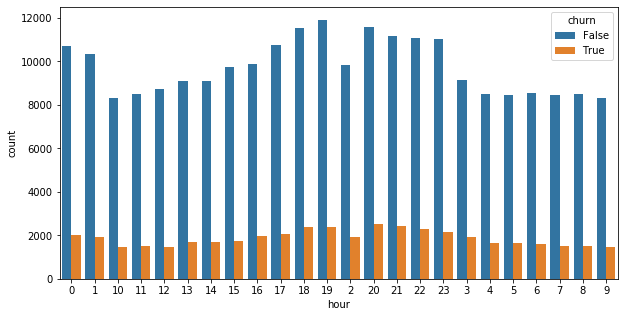

In [20]:
plot_cnt_by_churn("hour")


In [ ]:
plot_cnt_by_churn("weekday")

In [ ]:
plot_cnt_by_churn("day")

#### 2. Churn and the level of subscription

In [ ]:
plt.figure(figsize=(10,5))
df_level=user_log_with_churn.groupby(["churn", "level"]).count().sort("churn").toPandas()
sns.barplot(x='level', y='count', hue='churn', data=df_level)

looks like that free users churn slightly more than paid users.

#### 3. Churn and user location

In [ ]:
user_log_with_churn.select("location_state").distinct().count()

In [ ]:
plt.figure(figsize=(15,10))
df_location=user_log_with_churn.groupby(["location_state", "churn"]).count().sort("churn").toPandas()
sns.barplot(x='location_state', y='count', hue='churn', data=df_location);

There seem to be a dependency between location and churn rate. However, based on this graph alone, it is impossible to say whethere there are other factors influencing churn rates in particular states

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
#Total songs per user
song_per_user = user_log_with_churn.select("userId","song").groupby("userId").count().withColumnRenamed("count","song_per_user")
song_per_user.describe().show()

+-------+------------------+-----------------+
|summary|            userId|    song_per_user|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [22]:
# Gender
gender_num = user_log_with_churn.select('userId','gender').dropDuplicates().replace(['M','F'],['0','1'],'gender').select('userId',col('gender').cast('int')).withColumnRenamed('gender', 'gender_num') 
gender_num.describe().show()

+-------+------------------+-------------------+
|summary|            userId|         gender_num|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [23]:
# Thumbs up
thumbs_up = user_log_with_churn.select('userID','page').where(user_log_with_churn.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'thumbs_up') 
thumbs_up.describe().show()


+-------+------------------+-----------------+
|summary|            userID|        thumbs_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [24]:
# Thumbs down
thumbs_down = user_log_with_churn.select('userID','page').where(user_log_with_churn.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'thumbs_down')
thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userID|       thumbs_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [25]:
# Listening time
listening_time = user_log_with_churn.select('userId','length').groupby(['userId']).sum().withColumnRenamed('sum(length)','listening_time')

listening_time.describe().show()

+-------+------------------+------------------+
|summary|            userId|    listening_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155564|
| stddev|105396.47791907164| 275396.4038847638|
|    min|                10|         691.66884|
|    max|                99|1991154.9155800021|
+-------+------------------+------------------+



In [26]:
# Level
level_num = user_log_with_churn.select('userId','level').replace(['free','paid'],['0','1'],'level').select('userId',col('level').cast('int')).withColumnRenamed('level', 'level_num') 
level_num.describe().show()

+-------+------------------+------------------+
|summary|            userId|         level_num|
+-------+------------------+------------------+
|  count|            278154|            278154|
|   mean| 59682.02278593872|0.7996757192059075|
| stddev|109091.94999910559|0.4002437247984476|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [27]:
label = user_log_with_churn.select('userId','churn').replace(['True','False'],['1','0'],'churn').select('userId',col('churn').cast('int')).withColumnRenamed('churn', 'label') 
label.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              label|
+-------+------------------+-------------------+
|  count|            278154|             278154|
|   mean| 59682.02278593872|0.16129194618808287|
| stddev|109091.94999910559| 0.3678006805630892|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [28]:
# Joining data set 
data = song_per_user.join(gender_num,'userID','outer').join(thumbs_up,'userID','outer').join(thumbs_down, 'userID','outer').join(listening_time,'userID','outer').join(level_num,'userID','outer').join(label,'userID','outer').drop('userID').fillna(0)

data.show(5)

+-------------+----------+---------+-----------+--------------+---------+-----+
|song_per_user|gender_num|thumbs_up|thumbs_down|listening_time|level_num|label|
+-------------+----------+---------+-----------+--------------+---------+-----+
|          381|         1|       17|          5|   66940.89735|        0|    0|
|          381|         1|       17|          5|   66940.89735|        0|    0|
|          381|         1|       17|          5|   66940.89735|        0|    0|
|          381|         1|       17|          5|   66940.89735|        0|    0|
|          381|         1|       17|          5|   66940.89735|        0|    0|
+-------------+----------+---------+-----------+--------------+---------+-----+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [29]:
# Vector assembler
cols = ['song_per_user', 'gender_num', 'thumbs_up', 'thumbs_down','level_num','listening_time']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)


In [30]:
# Standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [31]:
# Splitting data into train and validation set
rest, validation = data.randomSplit([0.8, 0.2], seed=42)

In [32]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [33]:
f_score = MulticlassClassificationEvaluator(metricName='f1')

In [34]:
lr_train = lr.fit(rest)
lr_test = lr_train.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

print('Accuracy:')
print(evaluator.evaluate(lr_test,{evaluator.metricName: 'accuracy'}))
print('F-1 score:')
print(evaluator.evaluate(lr_test, {evaluator.metricName: 'f1'}))


Py4JJavaError: An error occurred while calling o433.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 14 in stage 87.0 failed 1 times, most recent failure: Lost task 14.0 in stage 87.0 (TID 6058, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.linalg.VectorUDT.<init>(VectorUDT.scala:96)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.CreateExternalRow_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1143)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1137)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1206)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1182)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:520)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:494)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:494)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:489)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:279)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.linalg.VectorUDT.<init>(VectorUDT.scala:96)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.CreateExternalRow_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.